In [14]:
import os
import sys
import math
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import pickle

print("Python:", sys.version.splitlines()[0])
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("TensorFlow:", tf.__version__)

Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
NumPy: 2.2.6
OpenCV: 4.12.0
TensorFlow: 2.20.0


In [15]:
DATASET_PATH = r"C:\Users\Jenifer\Downloads\ldem_512_00n_45n_000_090_float.img"  # <-- EDIT this path
OUTPUT_MODEL = "crater_detection_model.keras"
CLASS_MAP_PKL = "class_map.pkl"

PATCH_SIZE = 32      # patch width & height
STRIDE = 16          # overlapping patches recommended
TEST_SIZE = 0.20
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_STATE = 42

Loaded DEM shape: (8192, 8192)


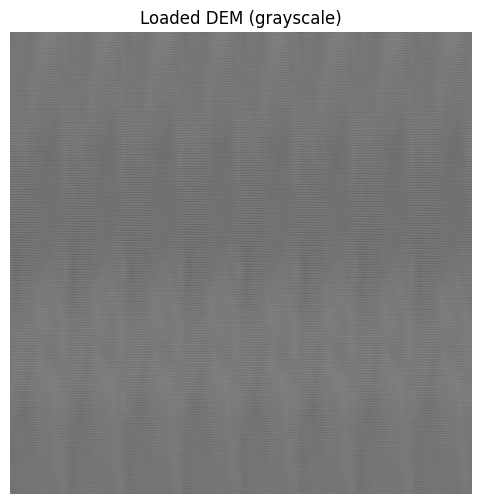

In [16]:
def infer_shape_from_flat_length(n_pixels, max_side=8192):
    # find factor pairs and choose the pair closest to square
    best_pair = None
    best_diff = None
    for a in range(1, int(math.sqrt(n_pixels)) + 1):
        if n_pixels % a == 0:
            b = n_pixels // a
            diff = abs(a - b)
            if best_diff is None or diff < best_diff:
                best_diff = diff
                best_pair = (a, b)
    # if no exact factorization found (rare), fall back to nearest square
    if best_pair is None:
        side = int(math.sqrt(n_pixels))
        return side, side
    h, w = best_pair
    # choose orientation: we want width >= height for typical visualization
    if w < h:
        h, w = w, h
    # sanity clamp
    h = min(h, max_side)
    w = min(w, max_side)
    return h, w

def load_img_raster(fp):
    fp = Path(fp)
    if not fp.exists():
        raise FileNotFoundError(f"File not found: {fp}")
    arr = np.fromfile(str(fp), dtype=np.float32)
    if arr.size == 0:
        raise ValueError("File appears empty or not float32.")
    h, w = infer_shape_from_flat_length(arr.size)
    if h * w != arr.size:
        # If inference produced different total, try trimming or padding
        tot = h * w
        if tot > arr.size:
            # pad with zeros
            pad = tot - arr.size
            arr = np.concatenate([arr, np.zeros(pad, dtype=np.float32)])
        else:
            arr = arr[:tot]
    dem = arr.reshape((h, w))
    return dem

# Load and visualize
dem = load_img_raster(DATASET_PATH)
print("Loaded DEM shape:", dem.shape)
plt.figure(figsize=(6,6))
plt.imshow(dem, cmap='gray')
plt.title("Loaded DEM (grayscale)")
plt.axis('off')
plt.show()

In [17]:
dem = cv2.normalize(dem.astype(np.float32), None, 0.0, 1.0, cv2.NORM_MINMAX)


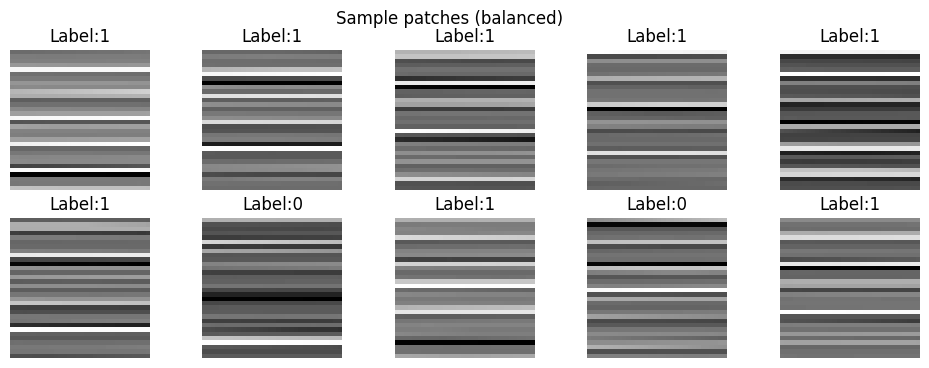

Extracted patches shape: (130560, 32, 32)
Label counts: [65280 65280]


In [18]:
def extract_and_label_patches(image, patch_size=32, stride=16, pctile=75, visualize=False, random_seed=RANDOM_STATE):
    """
    Returns: patches (N, patch_size, patch_size), labels (N,) where label=1 crater, 0 non-crater
    Labeling heuristic: patches with variance > percentile(variances, pctile) are labelled crater.
    Balanced by sampling equal counts from each class.
    """
    random.seed(random_seed)
    h, w = image.shape
    # collect variances
    variances = []
    coords = []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            p = image[y:y+patch_size, x:x+patch_size]
            variances.append(float(np.var(p)))
            coords.append((y, x))
    if len(variances) == 0:
        raise ValueError("No patches extracted. Image may be smaller than patch_size.")

    variances = np.array(variances)
    # adaptive threshold
    threshold = float(np.percentile(variances, pctile))
    if threshold == 0:
        # if everything near constant, fallback to median or a tiny epsilon
        threshold = float(np.median(variances)) if np.median(variances) > 0 else 1e-6

    patches = []
    labels = []
    for (y, x), var in zip(coords, variances):
        p = image[y:y+patch_size, x:x+patch_size]
        lbl = 1 if var > threshold else 0
        patches.append(p)
        labels.append(lbl)

    patches = np.array(patches)
    labels = np.array(labels)

    # If one class is missing, relax threshold to median
    unique, counts = np.unique(labels, return_counts=True)
    d = dict(zip(unique, counts))
    if len(d) == 1:
        # try median threshold
        threshold2 = float(np.median(variances))
        labels = np.array([1 if v > threshold2 else 0 for v in variances])
        unique, counts = np.unique(labels, return_counts=True)
        d = dict(zip(unique, counts))
        if len(d) == 1:
            raise ValueError("Auto-labeling produced a single class. You may need manual labels or different heuristic.")

    # balance dataset
    crater_idx = np.where(labels == 1)[0]
    non_idx = np.where(labels == 0)[0]
    min_len = min(len(crater_idx), len(non_idx))
    if min_len == 0:
        raise ValueError("No samples for one of the classes after labeling. Adjust parameters.")

    # sample without replacement (if not enough, allow replacement)
    if min_len < 1:
        raise ValueError("Not enough samples to balance.")
    crater_sample = np.random.choice(crater_idx, min_len, replace=(min_len > len(crater_idx)))
    non_sample = np.random.choice(non_idx, min_len, replace=(min_len > len(non_idx)))
    selected_idx = np.concatenate([crater_sample, non_sample])
    np.random.shuffle(selected_idx)

    patches_bal = patches[selected_idx]
    labels_bal = labels[selected_idx]

    # Optionally visualize
    if visualize:
        n_show = min(10, len(patches_bal))
        fig, axes = plt.subplots(2, n_show//2 or 1, figsize=(12, 4))
        axes = axes.ravel() if hasattr(axes, 'ravel') else [axes]
        for i in range(n_show):
            axes[i].imshow(patches_bal[i], cmap='gray')
            axes[i].set_title(f"Label:{labels_bal[i]}")
            axes[i].axis('off')
        plt.suptitle("Sample patches (balanced)")
        plt.show()

    return patches_bal, labels_bal

patches, labels = extract_and_label_patches(dem, patch_size=PATCH_SIZE, stride=STRIDE, visualize=True)
print("Extracted patches shape:", patches.shape)
print("Label counts:", np.bincount(labels))
# Expand channels for CNN
patches = np.expand_dims(patches, axis=-1).astype(np.float32)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(patches, labels, test_size=TEST_SIZE, stratify=labels, random_state=RANDOM_STATE)
print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)

# Convert labels
y_train = np.array(y_train).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

Train: (104448, 32, 32, 1) (104448,) Val: (26112, 32, 32, 1) (26112,)


In [20]:
def build_model(input_shape=(PATCH_SIZE, PATCH_SIZE, 1)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', name='last_conv')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,993 (394.50 KB)

 Trainable params: 100,993 (394.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
cb = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    callbacks.ModelCheckpoint(OUTPUT_MODEL, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Data augmentation using ImageDataGenerator (works with arrays)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                               zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='reflect')
val_gen = ImageDataGenerator()

train_flow = train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_flow = val_gen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

# Fit
history = model.fit(train_flow, validation_data=val_flow, epochs=EPOCHS, callbacks=cb, verbose=2)


Epoch 1/10

Epoch 1: val_accuracy improved from None to 0.63461, saving model to crater_detection_model.keras
3264/3264 - 90s - 28ms/step - accuracy: 0.9401 - loss: 0.1474 - val_accuracy: 0.6346 - val_loss: 2.0898
Epoch 2/10

Epoch 2: val_accuracy improved from 0.63461 to 0.64897, saving model to crater_detection_model.keras
3264/3264 - 88s - 27ms/step - accuracy: 0.9453 - loss: 0.1367 - val_accuracy: 0.6490 - val_loss: 1.6968
Epoch 3/10

Epoch 3: val_accuracy improved from 0.64897 to 0.65939, saving model to crater_detection_model.keras
3264/3264 - 110s - 34ms/step - accuracy: 0.9460 - loss: 0.1336 - val_accuracy: 0.6594 - val_loss: 1.4866
Epoch 4/10

Epoch 4: val_accuracy improved from 0.65939 to 0.72273, saving model to crater_detection_model.keras
3264/3264 - 113s - 35ms/step - accuracy: 0.9481 - loss: 0.1280 - val_accuracy: 0.7227 - val_loss: 1.1031
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.72273
3264/3264 - 108s - 33ms/step - accuracy: 0.9502 - loss: 0.1238 - val_a

In [23]:
print("\nEvaluating on validation set:")
res = model.evaluate(X_val, y_val, verbose=2)
print("Val loss, val acc:", res)



Evaluating on validation set:
816/816 - 8s - 9ms/step - accuracy: 0.7408 - loss: 1.1195
Val loss, val acc: [1.119511365890503, 0.740847110748291]


In [25]:
import pickle

# Define and save the class map properly
class_map = {0: "no_crater", 1: "crater"}
CLASS_MAP_PKL = "class_map.pkl"

with open(CLASS_MAP_PKL, "wb") as f:
    pickle.dump(class_map, f)

print(f"✅ Saved class map: {class_map}")
print(f"📁 File saved at: {os.path.abspath(CLASS_MAP_PKL)}")



✅ Saved class map: {0: 'no_crater', 1: 'crater'}
📁 File saved at: c:\Users\Jenifer\class_map.pkl


In [26]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='last_conv', eps=1e-8):
    """
    img_array: 1 x H x W x C, dtype=float32 in [0,1]
    returns heatmap resized to HxW (values 0..1)
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        # for binary sigmoid output, preds shape (1,1)
        top_class_channel = preds[:, 0]
    grads = tape.gradient(top_class_channel, conv_outputs)
    # global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()
    # weight combine
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[..., i] *= pooled_grads[i]
    heatmap = np.sum(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) == 0:
        return np.zeros((img_array.shape[1], img_array.shape[2]))
    heatmap = heatmap / (np.max(heatmap) + eps)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    return heatmap

def overlay_heatmap_on_patch(patch, heatmap, alpha=0.4):
    """
    patch: HxW (float 0..1)
    heatmap: HxW (float 0..1)
    returns: RGB overlay (uint8)
    """
    patch_uint8 = np.uint8(255 * np.clip(patch, 0, 1))
    patch_rgb = cv2.cvtColor(patch_uint8, cv2.COLOR_GRAY2BGR)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, patch_rgb, 1 - alpha, 0)
    return overlay

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


c:\Users\Jenifer\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 32, 32, 1))
  warnings.warn(msg)


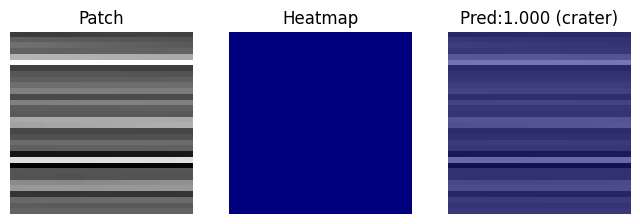

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


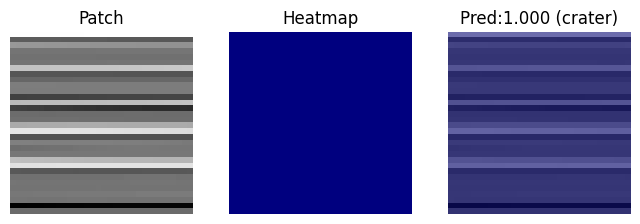

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


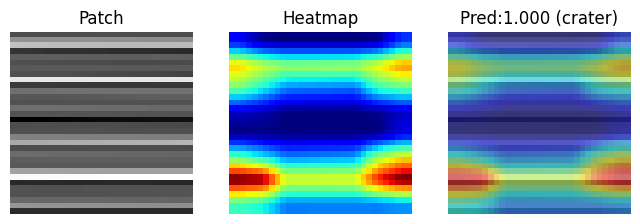

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


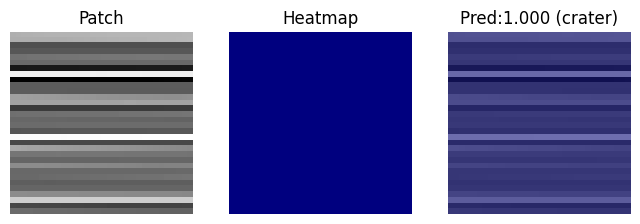

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


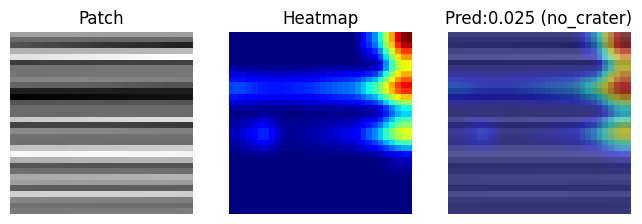

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


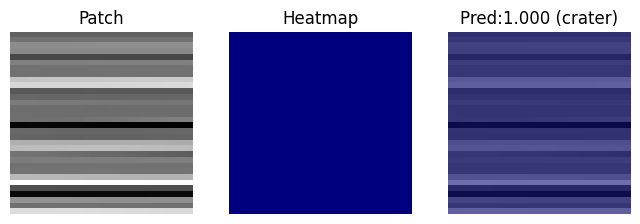

In [27]:
model_best = tf.keras.models.load_model(OUTPUT_MODEL) if os.path.exists(OUTPUT_MODEL) else model
indices = np.random.choice(len(X_val), size=min(6, len(X_val)), replace=False)
for idx in indices:
    patch = X_val[idx:idx+1]  # shape 1,H,W,1
    pred = model_best.predict(patch)[0][0]
    pred_label = 1 if pred >= 0.5 else 0
    heatmap = make_gradcam_heatmap(patch, model_best, last_conv_layer_name='last_conv')
    overlay = overlay_heatmap_on_patch(patch[0,:,:,0], heatmap, alpha=0.5)
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(patch[0,:,:,0], cmap='gray'); plt.title("Patch"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap='jet'); plt.title("Heatmap"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); 
    plt.title(f"Pred:{pred:.3f} ({class_map[pred_label]})"); plt.axis('off')
    plt.show()

In [ ]:


model_best.save(OUTPUT_MODEL)
print("Final model saved:", OUTPUT_MODEL)

Final model saved: crater_detection_model.keras
